In [1]:
import numpy as np
import os
import pickle
import shutil
import random
import warnings
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

warnings.filterwarnings('ignore')

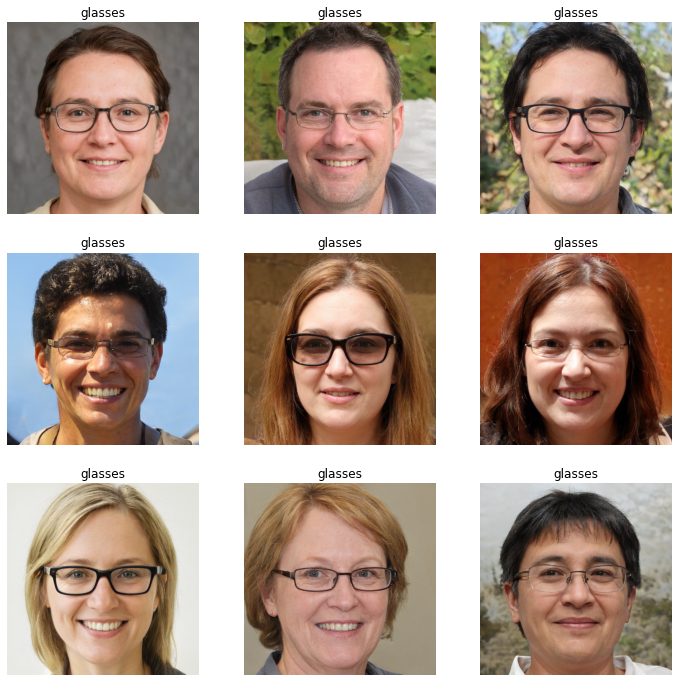

In [2]:
''' reading glasses data'''
with open("../input/datacleaningglassesnoglasses/glasses.txt", "rb") as fp:
    glass = pickle.load(fp)

''' taking 16 random numbers '''
random_number = []
for _ in range(0,16):
    n = random.randint(0,len(glasses))
    random_number.append(n)
    
''' plotting some random images '''
plt.figure(figsize=(10, 10))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(glass[random_number[i]]))
    plt.title("Glasses", fontsize=20)
    plt.axis("off")

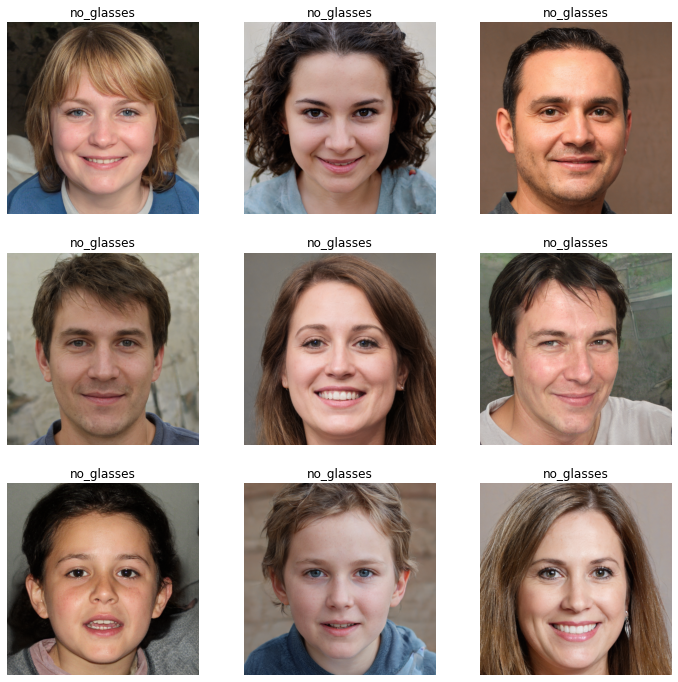

In [3]:
''' reading no_glasses data '''
with open("../input/datacleaningglassesnoglasses/no_glasses.txt", "rb") as fp: 
    no_glass = pickle.load(fp)

''' taking 16 random numbers '''
random_number = []
for _ in range(0,16):
    n = random.randint(0,len(no_glass))
    random_number.append(n)

''' plotting some random images '''
plt.figure(figsize=(10, 10))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(no_glass[random_number[i]]))
    plt.title("no_glasses", fontsize=20)
    plt.axis("off")

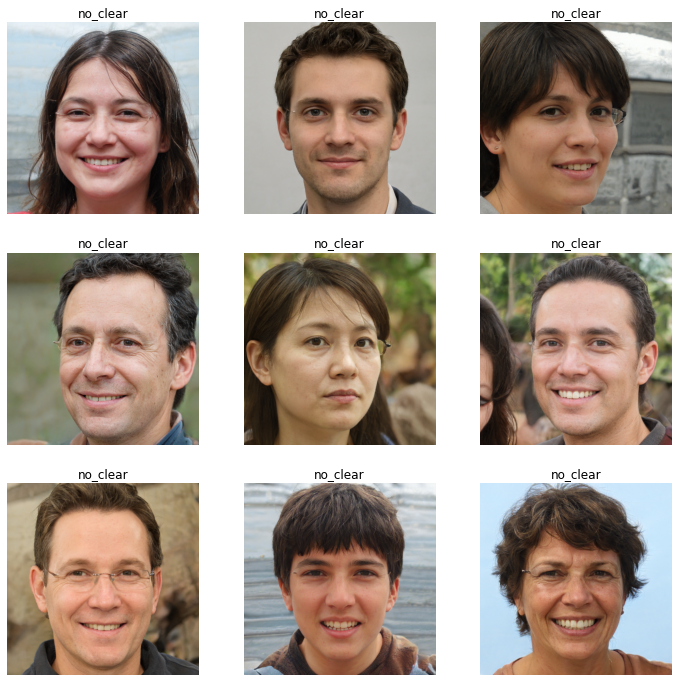

In [4]:
''' reading no_clear data '''
with open("../input/datacleaningglassesnoglasses/no_clear.txt", "rb") as fp: 
    no_clear = pickle.load(fp)

''' taking 16 random numbers '''

random_number = []
for _ in range(0,9):
    n = random.randint(0,len(no_clear))
    random_number.append(n)

''' plotting some random images'''
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(no_clear[random_number[i]]))
    plt.title("no_clear", fontsize=20)
    plt.axis("off")

In [5]:
print("The length of the different groups:" + "-Glasses: " + str(len(glass)) + " -No glasses: " + str(len(no_glass)) + " -No clear: " + str(len(no_clear)))

The length of the different groups:-Glasses: 2770 -No glasses: 2152 -No clear: 77


In [6]:
''' setting radom seed'''
tf.random.set_seed(123456)

In [7]:
''' initializing batch size and image size '''
batch_size = 64
IMG_SIZE = (150, 150)

In [8]:
''' total images '''
total_images= glasses + no_glasses

In [9]:
''' data directory '''
dataset_dir= "/kaggle/input/datacleaningglassesnoglasses/Images/Images/"

In [10]:
''' splitting data into 70-30 split'''

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 3444 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 1476 files for validation.


In [12]:
''' It seems the train_dataset contains 4920 images, and the validation_datset 1476, out of 4920 files '''
c_names = train_dataset.class_names
print(c_names)

['glasses', 'no_glasses']


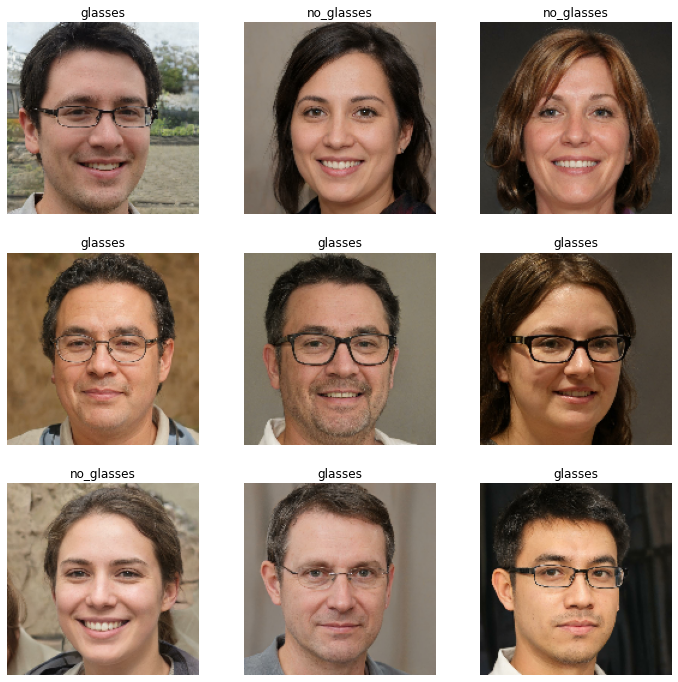

In [13]:
''' plotting images from training data '''

''' taking class names'''
c_names = train_dataset.class_names

''' plotting '''
plt.figure(figsize=(12, 12))
for img, lbl in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(c_names[lbl[i]])
        plt.axis("off")

In [14]:
''' splitting data into from validation data into val and test'''
val_data = tf.data.experimental.cardinality(validation_dataset)
test_ds = validation_dataset.take(val_data // 5)
val_ds = validation_dataset.skip(val_batches // 5)

In [15]:
''' Number of batches in each data '''
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 108
Number of validation batches: 38
Number of test batches: 9


In [16]:
''' This configuration allows the model to speed up the training process '''
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
''' doing data augmentation '''
augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

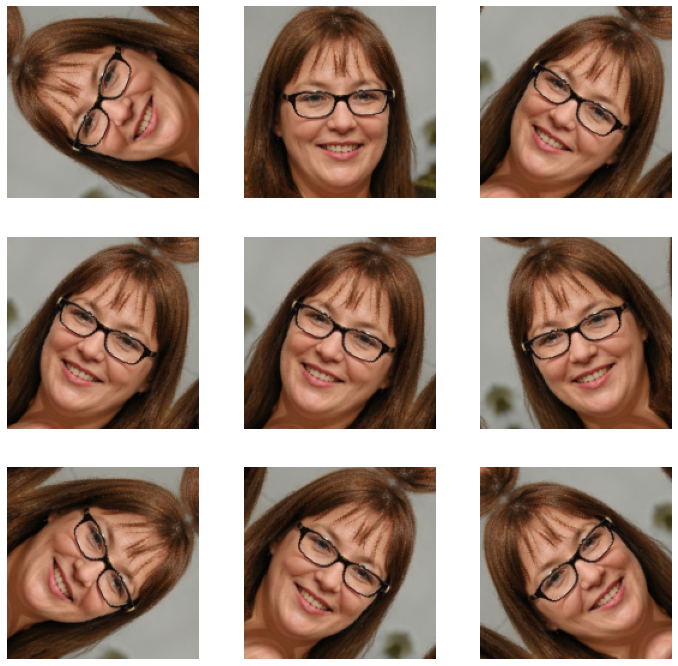

In [18]:
''' images afer doing data augmentation '''

''' plotting some images '''
for img, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    img = img[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augm_img = augmentation(tf.expand_dims(img, 0))
        plt.imshow(augm_img[0] / 255)
        plt.axis('off')

In [19]:
''' mobilenet preprocess input'''
pre_process_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [20]:
''' scaling images, scaling brings the values of each pixle in range between -1 to 1 '''
sc = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [21]:
''' reshaping'''
IMAGE_SHAPE = IMG_SIZE + (3,)

''' MobileNetV2 Model '''
model1 = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [22]:
''' This feature extractor converts the images from 160x160x3 to 5x5x1280 '''
img_batch, lbl_batch = next(iter(train_ds))
feature_batch = model1(img_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [23]:
''' freeze top layers'''
model1.trainable = False

In [24]:
''' adding GlobalAveragePooling2D layers '''
g_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
batch_avg = g_avg_layer(feature_batch)
print(batch_avg.shape)

(32, 1280)


In [25]:
''' Adding Dense Layer, that helps in classification '''
clf_layer = tf.keras.layers.Dense(1)
pred_batch = clf_layer(batch_avg)
print(pred_batch.shape)

(32, 1)


In [26]:
''' aggregating all the things '''
inp = tf.keras.Input(shape=(160, 160, 3))
x = augmentation(inp)
x = pre_process_input(x)
x = model1(x, training=False)
x = g_avg_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
out = clf_layer(x)

''' final model '''
model = tf.keras.Model(inp, out)

In [27]:
''' model looks like '''
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [28]:
''' setting up optimizer and loss '''
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
''' evaluating model '''
epochs = 10
loss0, accuracy0 = model.evaluate(val_ds)

38/38 [==============================] - 15s 229ms/step - loss: 0.7179 - accuracy: 0.5691


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.59


In [32]:
''' training '''
model_fit = model.fit(train_ds,
                    epochs= epochs,
                    validation_data= val_ds)

Epoch 1/10
108/108 [==============================] - 39s 329ms/step - loss: 0.6983 - accuracy: 0.6039 - val_loss: 0.6091 - val_accuracy: 0.6675
Epoch 2/10
108/108 [==============================] - 22s 193ms/step - loss: 0.5593 - accuracy: 0.7015 - val_loss: 0.5382 - val_accuracy: 0.7315
Epoch 3/10
108/108 [==============================] - 22s 193ms/step - loss: 0.4581 - accuracy: 0.7729 - val_loss: 0.4795 - val_accuracy: 0.7710
Epoch 4/10
108/108 [==============================] - 22s 190ms/step - loss: 0.4017 - accuracy: 0.8139 - val_loss: 0.4317 - val_accuracy: 0.8131
Epoch 5/10
108/108 [==============================] - 22s 194ms/step - loss: 0.3524 - accuracy: 0.8473 - val_loss: 0.3989 - val_accuracy: 0.8333
Epoch 6/10
108/108 [==============================] - 22s 193ms/step - loss: 0.3182 - accuracy: 0.8693 - val_loss: 0.3638 - val_accuracy: 0.8502
Epoch 7/10
108/108 [==============================] - 22s 190ms/step - loss: 0.2885 - accuracy: 0.8821 - val_loss: 0.3399 - val_ac

In [33]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

In [34]:
## 3.8) Results

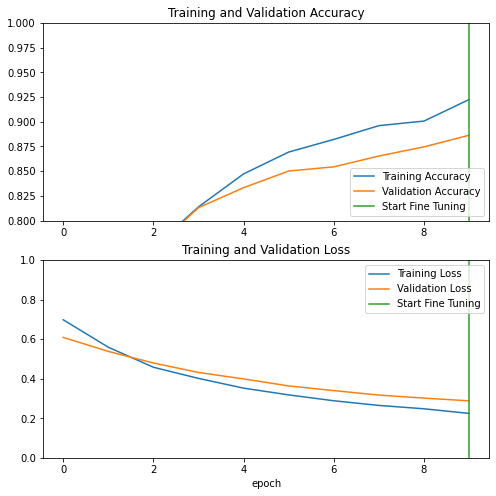

In [35]:
''' plotting accuracy and val accuray graph '''
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



''' plotting loss and validation loss graph '''
plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
''' evaluation '''
loss, acc = model.evaluate(test_ds)
loss, acc1 = model.evaluate(train_ds)
print('Test accuracy :', acc)
print('Train accuracy :', acc1)

108/108 [==============================] - 15s 130ms/step - loss: 0.2691 - accuracy: 0.8972
Test accuracy : 0.9201388955116272
Train accuracy : 0.897212564945221


In [37]:
''' unfreeze the top layers '''
model1.trainable = True

In [38]:
''' Tunning of model '''

print("Number of layers in the base model: ", len(base_model.layers))
tune_at = 90
for layer in model.layers[:tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [39]:
''' Compile '''
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [41]:
''' training '''
tune_epochs  = 5
total_epochs =  epochs + tune_epohcs

history_tune = model.fit(train_ds,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= val_ds)

Epoch 10/15
108/108 [==============================] - 27s 205ms/step - loss: 0.1048 - accuracy: 0.9575 - val_loss: 0.0401 - val_accuracy: 0.9899
Epoch 11/15
108/108 [==============================] - 23s 202ms/step - loss: 0.0298 - accuracy: 0.9913 - val_loss: 0.0212 - val_accuracy: 0.9949
Epoch 12/15
108/108 [==============================] - 22s 198ms/step - loss: 0.0232 - accuracy: 0.9920 - val_loss: 0.0182 - val_accuracy: 0.9924
Epoch 13/15
108/108 [==============================] - 22s 192ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0183 - val_accuracy: 0.9949
Epoch 14/15
108/108 [==============================] - 23s 196ms/step - loss: 0.0124 - accuracy: 0.9935 - val_loss: 0.0290 - val_accuracy: 0.9933
Epoch 15/15
108/108 [==============================] - 23s 198ms/step - loss: 0.0106 - accuracy: 0.9963 - val_loss: 0.0097 - val_accuracy: 0.9975


In [42]:
acc += history_tune.history['accuracy']
val_acc += history_tune.history['val_accuracy']
loss_ += history_tune.history['loss']
val_loss_ += history_tune.history['val_loss']

## 4.4) Results

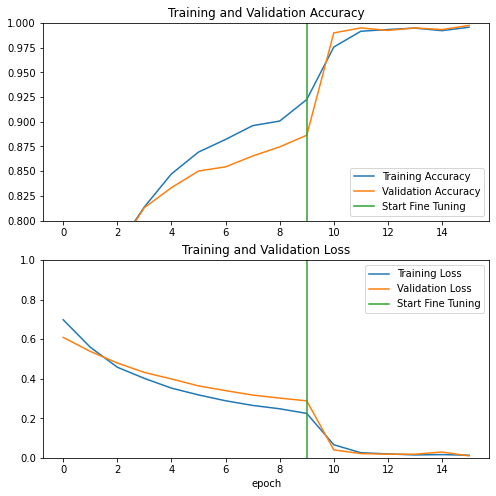

In [43]:
''' Training and Validation accuracy graph'''
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


''' Training and Validation loss graph'''
plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
''' evalutaion '''
loss, acc = model.evaluate(test_dataset)
loss, acc1 = model.evaluate(train_dataset)
loss, acc2 = model.evaluate(validation_dataset)
print('Test accuracy :', acc)
print('Train accuracy :', acc1)
print('Validation accuracy :', acc2)

38/38 [==============================] - 7s 117ms/step - loss: 0.0130 - accuracy: 0.9966
Test accuracy : 1.0
Train accuracy : 0.9970964193344116
Validation accuracy : 0.996632993221283


Raw Predictions:
 [-13.872748   10.696712   -9.448843    5.618803  -10.39617   -12.857973
 -14.004727    6.401125  -12.403422    9.034582  -13.961787    8.715623
  -8.567397   13.698115  -13.166444  -13.6628065 -12.80216   -13.691825
  -8.191202    8.295118  -13.211011   -6.726824    9.223227    7.321108
   7.2259426  10.592753  -13.814826  -11.242897    9.009648   11.78903
  -9.652008    7.998388 ]
Raw Predictions 2:
 tf.Tensor(
[9.4436854e-07 9.9997735e-01 7.8774458e-05 9.9638414e-01 3.0548341e-05
 2.6052662e-06 8.2760636e-07 9.9834311e-01 4.1045005e-06 9.9988079e-01
 8.6391793e-07 9.9983597e-01 1.9017093e-04 9.9999893e-01 1.9137503e-06
 1.1649788e-06 2.7548074e-06 1.1316587e-06 2.7700386e-04 9.9975032e-01
 1.8303327e-06 1.1968988e-03 9.9990129e-01 9.9933904e-01 9.9927312e-01
 9.9997485e-01 1.0006838e-06 1.3099845e-05 9.9987781e-01 9.9999237e-01
 6.4292195e-05 9.9966407e-01], shape=(32,), dtype=float32)
Predictions:
 [0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1]
L

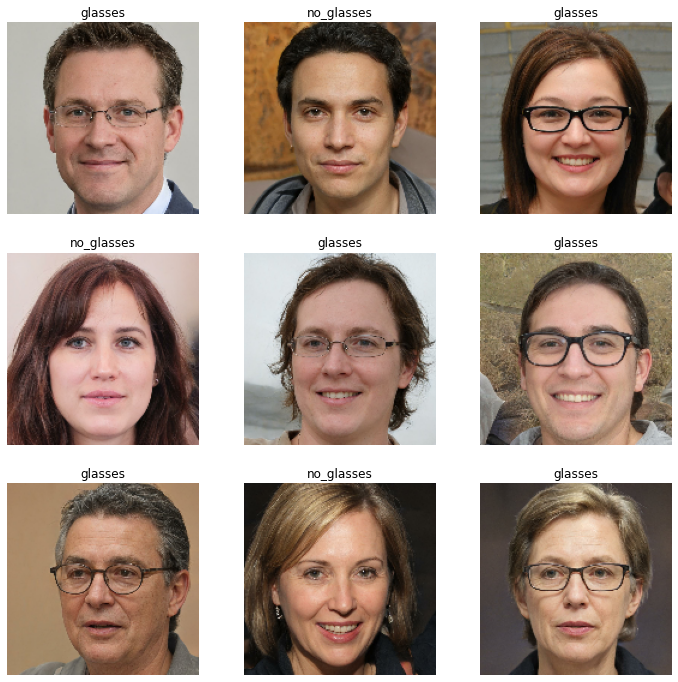

In [45]:
''' prediction '''
img_batch, lbl_batch = test_ds.as_numpy_iterator().next()
pred = model.predict_on_batch(img_batch).flatten()

print('Raw pred:\n', pred)

pred = tf.nn.sigmoid(pred)

print('Raw pred 2:\n', pred)

pred = tf.where(pred < 0.5, 0, 1)

print('pred:\n', pred.numpy())
print('Labels:\n', lbl_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_batch[i].astype("uint8"))
    plt.title(class_names[pred[i]])
    plt.axis("off")